In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchmetrics import R2Score, MeanSquaredError

r2score = R2Score()
msescore = MeanSquaredError()

torch.manual_seed(0)

c:\Users\tln229\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Model (system)
class System(torch.nn.Module):
    def __init__(self):
        super(System, self).__init__()
        self.input_ini    = torch.nn.Linear(1, 12)
        self.input_signal = torch.nn.Linear(10,12)
        self.input_t      = torch.nn.Linear(1, 12)

    def forward(self, x_0, u, t):
        z_ini   = torch.selu(self.input_ini(x_0))
        z_input = torch.selu(self.input_signal(u))
        z_t     = torch.selu(self.input_t(t))
        z       = z_ini * z_input * z_t
        z       = torch.sum(z).reshape(-1,1)
        return z

In [3]:
class MPC(torch.nn.Module):
    def __init__(self, T):
        super(MPC, self).__init__()
        self.u = torch.nn.Parameter(torch.ones(T))

    def forward(self, system, umin, umax, y0, yT, R, Q, U):
        u = self.u
        lu = torch.relu(umin-u).sum() + torch.relu(u-umax).sum()
        l1 = ((u[1:] - u[0:-1]).sum().expand(1))**2
        l2 = 0
        for i in range(10):
            y1 = system(y0, u, torch.tensor([i*1.0]))
            l2 = l2 + (y1-yT)**2
        loss = R*l1 + Q*l2 + U*lu
        return loss

In [4]:
# Train function
loss_function = torch.nn.MSELoss()
def train(system, mpc, umin, umax, y0, yT, R, Q, U, epochs, _lr):
    opt = torch.optim.Adam(mpc.parameters(), lr=_lr)
    for epoch in range(epochs+1):
        opt.zero_grad()
        loss = loss_function(mpc(system, umin, umax, y0, yT, R, Q, U), torch.tensor([[0.]]))
        loss.backward(retain_graph=True)
        opt.step()

In [5]:
# parameter for MPC
N  = 480                            # prediction horizon length
T  = 10                             # control horizon length
y0 = torch.tensor([20.])            # y0
yT = torch.tensor([60.])            # yT
umin = 0                            # u min
umax = 100                          # u max
R = 1e2                             # input change penalty
Q = 1e0                             # reference difference penalty
U = 1e9                             # input violation penalty

In [6]:
# plant
system = torch.load('system.pt')

# model
mpc = MPC(T)

# Train MPC
u_vector = np.zeros(N+1)
y_vector = np.zeros(N+1)
y_vector[0] = y0.detach().numpy()[0]

for i in range(N):
    train(system, mpc, umin, umax, y0, yT, R, Q, U, epochs=100, _lr=0.01)
    u = mpc.u
    y0 = system(y0, u, torch.tensor([1.])).data
    u_vector[1+i] = u.detach().numpy()[0]
    y_vector[1+i] = y0.detach().numpy()[0]

    if(i%20 == 0):
        print("u = %5.3f \t y = %5.3f" % (u.detach().numpy()[0], y0.detach().numpy()[0]))

u = 1.469 	 y = 18.635
u = 1.550 	 y = 4.492
u = 0.049 	 y = 5.744
u = 0.047 	 y = 9.265
u = 0.050 	 y = 13.448
u = 0.051 	 y = 17.662
u = 0.047 	 y = 21.387
u = 0.033 	 y = 23.872
u = 0.018 	 y = 25.199
u = 0.036 	 y = 28.027
u = 0.562 	 y = 41.823
u = 2.406 	 y = 76.945
u = 5.323 	 y = 109.623
u = 11.670 	 y = 76.693
u = 12.311 	 y = 60.986
u = 9.728 	 y = 59.825
u = 6.591 	 y = 60.185
u = 5.140 	 y = 60.103
u = 4.405 	 y = 60.067
u = 3.947 	 y = 60.045
u = 3.663 	 y = 60.030
u = 3.648 	 y = 60.028
u = 3.631 	 y = 60.024
u = 3.617 	 y = 60.021


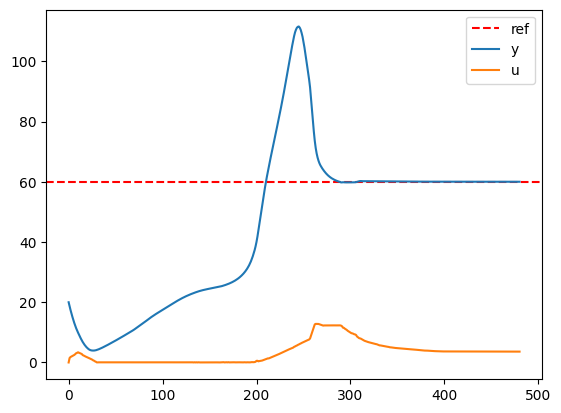

In [7]:
# Plot
plt.axhline(y = yT.detach().numpy()[0], color = 'r', linestyle = '--', label='ref')
plt.plot(y_vector, label='y')
plt.plot(u_vector, label='u')
plt.legend()
plt.show()